In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!nvidia-smi

Sun Mar  9 18:04:37 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.04             Driver Version: 570.124.04     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A5000               Off |   00000000:01:00.0 Off |                  Off |
| 69%   84C    P2            194W /  230W |   17278MiB /  24564MiB |     99%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import os

if 'notebooks' in os.getcwd():
    os.chdir("..")


from datasets import load_dataset, Dataset
from huggingface_hub import notebook_login
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
import time
import csv
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import aiohttp
import asyncio
from tqdm.asyncio import tqdm
import torch
import scienceplots
plt.style.use(['science', 'no-latex'])
from IPython.display import clear_output

from src.text_utils import trim_text_to_token_limit
from unsloth import FastLanguageModel
from unsloth.chat_templates import get_chat_template
from langdetect import detect

from src.train_test_split import stratified_train_test_split

import evaluate


tqdm.pandas()

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


# Hyperparameter search on lora rank

In this notebook, we have already trained models and generated validation summaries for each LoRA rank $ r \in \{8, 16, 32, 64\} $. While higher ranks allow for greater modifications to the model's output, they also increase the risk of overfitting and come with a higher computational cost.  

To determine the optimal $r $, we will evaluate performance using metrics such as text length, BERTScore, and ROUGE.

In [4]:
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-0.5B-Instruct", cache_dir = '/Data')

In [5]:
torch.cuda.set_per_process_memory_fraction(0.6, device=0)


In [6]:
base_data = pd.read_json("data/wikipedia_dataset.json")

In [7]:
train_df , temp_df = stratified_train_test_split(base_data, test_size=0.4)
val_df , test_df = stratified_train_test_split(temp_df, test_size=0.5)
train_idx = train_df.id.tolist()
val_idx = val_df.id.tolist()
test_idx = test_df.id.tolist()

## Loading data

In [8]:
base_path = "data/generated_dataset_test_100_qwen-0.5b-instruct-summary-pt-rank{lora_rank}.pkl"

In [9]:
all_df = []
raw_model_df = pd.read_pickle("data/generated_dataset_Qwen2.5-0.5B-Instruct.pkl")
raw_model_df['lora_rank'] = 0

all_df.append(raw_model_df)

for lora_rank in [8,16,32,64]:
    temp = pd.read_pickle(base_path.format(lora_rank = lora_rank))
    
    temp['lora_rank'] = lora_rank
    all_df.append(temp)


In [10]:
reference_summary = pd.read_pickle("data/generated_dataset_100_Meta-Llama-3.1-8B-Instruct-bnb-4bit_2.pkl")\
    .rename(columns = {'generated_text': 'reference_summary'})

# all_df.append(reference_summary)

In [11]:
generated_summaries = pd.concat(all_df, ignore_index=True)
generated_summaries

,id,generated_text,lora_rank
0,57237,A Los Angeles Lakers é uma equipe de basqueteb...,0
1,10306,O elétron é uma partícula subatômica com símbo...,0
2,2118886,"A rainha Sofia, filha do rei Constantino I, fo...",0
3,1695,Aqui está um resumo do texto em português:\n\n...,0
4,5448408,A crise migratória venezuelana é uma emigração...,0
...,...,...,...
12995,5968453,O texto não fornece um resumo de no máximo 100...,64
12996,10830,"O texto apresenta eventos históricos, incluind...",64
12997,10667,"O texto apresenta eventos históricos, incluind...",64
12998,10894,"O texto apresenta eventos históricos, incluind...",64


In [12]:
validation_mask = generated_summaries\
    .id\
    .isin(val_idx)
validation_summaries = generated_summaries[validation_mask]

In [13]:
df = pd.merge(
    validation_summaries,
    reference_summary,
    on='id',
    how = 'left'
)
df

,id,generated_text,lora_rank,reference_summary
0,325829,Por Água Abaixo é um filme de animação britâni...,0,Por Água Abaixo (Flushed Away) é um filme de a...
1,1354,"A Noruega é uma região noruega, situada na Eur...",0,A Noruega é um país nórdico localizado na Euro...
2,4080563,Jorge de Gales é um aristocrata britânico que ...,0,O príncipe Jorge de Gales é o filho primogênit...
3,10319,Aqui está um resumo do texto em português:\n\n...,0,JPEG é um método de compressão de imagens que ...
4,1549,"Pequim é a capital do país chinês, a maior cid...",0,Pequim é a capital da República Popular da Chi...
...,...,...,...,...
4995,5741577,A Federação Líbia de Voleibol (LVF) é uma orga...,64,A Federação Líbia de Voleibol (LVF) é uma orga...
4996,191038,Aqui está um resumo de no máximo 100 palavras ...,64,O texto não apresenta informações específicas ...
4997,5968453,O texto não fornece um resumo de no máximo 100...,64,O texto parece ser uma sequência de números. N...
4998,10667,"O texto apresenta eventos históricos, incluind...",64,"Infelizmente, não há texto disponível para ger..."


## Sequence length

We verify if the summary has ~ 100 words

In [14]:
df['reference_length'] = df['reference_summary']\
    .progress_apply(lambda x: len(x.split()))
df['generated_length'] = df['generated_text']\
    .progress_apply(lambda x: len(x.split()))

100%|██████████| 5000/5000 [00:00<00:00, 112816.22it/s]


<Axes: xlabel='reference_length', ylabel='Count'>

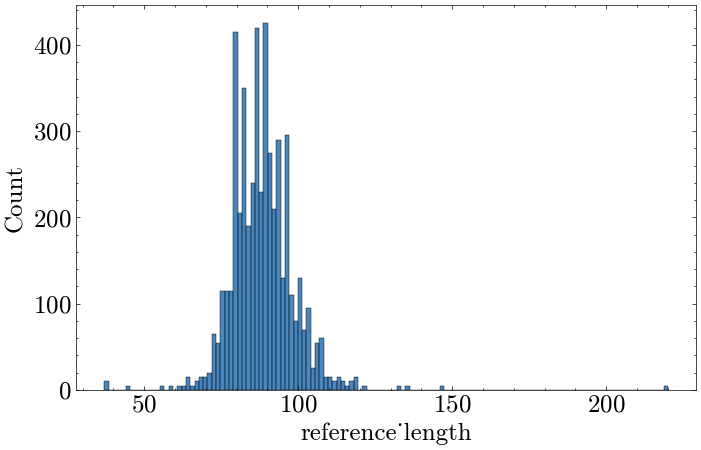

In [15]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize = (8,5))
sns.histplot(
    df,
    x = 'reference_length',
)

Text(0.5, 0, 'Lora Rank')

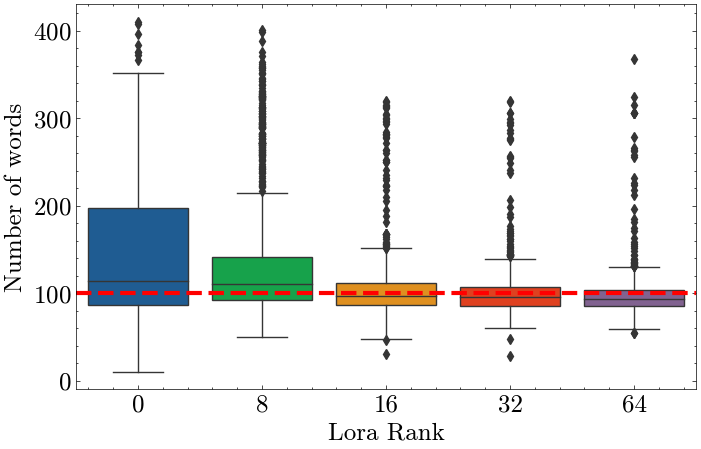

In [ ]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize = (8,5))
sns.boxplot(
    df,
    y = 'generated_length',
    x='lora_rank',
    # palette= 'viridis_r',
    # alpha = 0.6
)

plt.hlines(100, xmin=-0.5, xmax = 4.5, colors='black', linestyles='dashed', linewidth = 3, label = 'Target')

plt.ylabel("Number of words")
plt.xlabel("Lora Rank")
plt.legend()

Text(0.5, 0, 'Number of words')

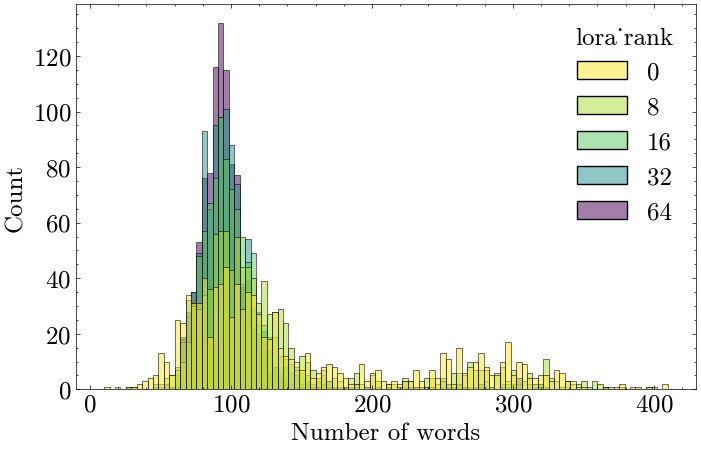

In [31]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize = (8,5))
sns.histplot(
    df,
    x = 'generated_length',
    hue='lora_rank',
    palette= 'viridis_r',
    # alpha = 0.6
)

plt.xlabel("Number of words")

In [67]:
df.groupby("lora_rank")\
    .generated_length\
    .describe()

,count,mean,std,min,25%,50%,75%,max
lora_rank,,,,,,,,
0,1000.0,147.066,83.871987,10.0,86.75,114.0,197.25,410.0
8,1000.0,137.450,72.866529,50.0,92.00,110.0,141.00,401.0
16,1000.0,105.459,38.573232,30.0,86.00,97.0,112.00,319.0
32,1000.0,100.440,31.623099,28.0,85.00,95.0,107.00,319.0
64,1000.0,97.752,29.174538,54.0,85.00,93.0,103.00,367.0


## Language

Checking how many texts are not in portuguese

In [32]:
df['language'] = df['generated_text'].progress_apply(detect)

100%|██████████| 5000/5000 [00:10<00:00, 457.65it/s]


In [34]:
def count_non_portuguese_text(df):
    return (df['language'] != 'pt').sum()/len(df)

df.groupby("lora_rank")\
    .progress_apply(count_non_portuguese_text)

100%|██████████| 5/5 [00:00<00:00, 1945.05it/s]


lora_rank
0     0.014
8     0.004
16    0.003
32    0.003
64    0.005
dtype: float64

In [35]:
predictions = df["generated_text"].tolist()
references = df["reference_summary"].tolist()

In [36]:
checkpoint_groups = df.groupby("lora_rank")
rouge = evaluate.load("rouge")
# Store results
checkpoint_rouge_scores = {}

# Iterate over each checkpoint with tqdm
for checkpoint, group in tqdm(checkpoint_groups, desc="Computing ROUGE per checkpoint"):
    predictions = group["generated_text"].tolist()
    references = group["reference_summary"].tolist()
    
    # Compute ROUGE for this checkpoint
    scores = rouge.compute(predictions=predictions, references=references)
    
    # Store the results
    checkpoint_rouge_scores[checkpoint] = scores

Computing ROUGE per checkpoint: 100%|██████████| 5/5 [00:22<00:00,  4.41s/it]


In [37]:
pd.DataFrame(checkpoint_rouge_scores).T

,rouge1,rouge2,rougeL,rougeLsum
0,0.405660,0.209729,0.292530,0.294251
8,0.478445,0.276309,0.359151,0.360555
16,0.520738,0.303913,0.390486,0.391744
32,0.534906,0.315144,0.400478,0.401702
64,0.543013,0.323542,0.409636,0.410853


In [38]:
checkpoint_groups = df.groupby("lora_rank")
bertscore = evaluate.load("bertscore")

# Store results
checkpoint_bert_scores = {}

# Iterate over each checkpoint with tqdm
for checkpoint, group in tqdm(checkpoint_groups, desc="Computing BERT-SCORE per checkpoint"):
    predictions = group["generated_text"].tolist()
    references = group["reference_summary"].tolist()
    
    # Compute ROUGE for this checkpoint
    scores = bertscore.compute(predictions=predictions, references=references, lang = 'pt',)
    
    # Store the results
    checkpoint_bert_scores[checkpoint] = scores

Computing BERT-SCORE per checkpoint: 100%|██████████| 5/5 [00:45<00:00,  9.16s/it]


In [42]:
temp = pd.DataFrame(checkpoint_bert_scores)\
    .loc['f1']\
    .to_dict()


<Axes: xlabel='BertScore', ylabel='Proportion'>

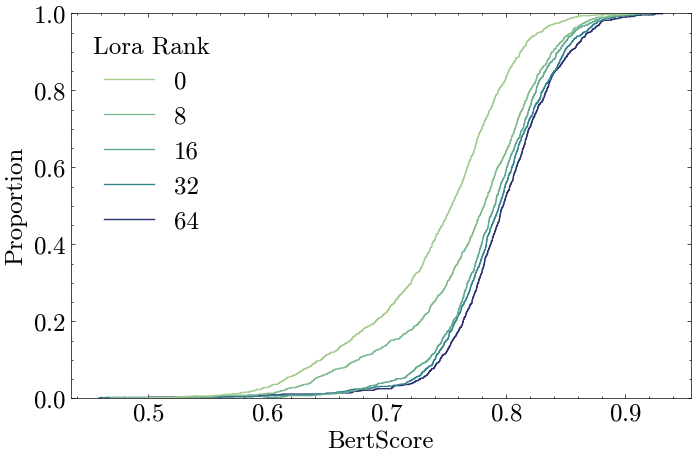

In [85]:
data = pd.DataFrame(temp).melt(var_name='Lora Rank', value_name='BertScore')

plt.rcParams.update({'font.size': 18})
plt.figure(figsize = (8,5))
sns.ecdfplot(
    data,
    hue = 'Lora Rank',
    x = 'BertScore',
    palette='crest'
)

In [51]:
for k in checkpoint_bert_scores.keys():
    print(k, np.mean(checkpoint_bert_scores[k]['f1']))

0 0.7414662988781929
8 0.7700064035058022
16 0.7880402990579605
32 0.7920641766488552
64 0.7962603651583194
